## Pytorch Geometric 

https://github.com/rusty1s/pytorch_geometric

In [13]:
# Install required packages.
# !pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
# !pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
# !pip install -q torch-geometric

# Helper function for visualization.
%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt


def visualize(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

PyTorch Geometric提供了很多的数实验据集，我们可以通过torch_geometric.datasets来进行使用

我们先来看一个简单的例子，KarateClub数据集是一个简单的社交网络数据集，其中包含了karate club的34个会员与他们在俱乐部外活动的一个人员关系，这里我们通过他们的社区信息做个简单的节点分类。

In [14]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


加载完数据之后，首先，我们可以看一下图中每个节点的属性，例如，我们可以看到这个数据集正好包含一个图，并且这个数据集中的每个节点都被分配了一个34维的特征向量。此外，该图正好包含4个类，它们表示每个节点所属的社区。


In [15]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(edge_index=[2, 156], train_mask=[34], x=[34, 34], y=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


PyTorch Geometric中的每个图都由一个数据对象表示，该数据对象包含描述其图表示的所有信息。

```
Data(edge_index=[2, 156], x=[34, 34], y=[34], train_mask=[34])
```

从上面的数据，我们可以看到，Data包含了四个字段，edge_index表示的是边，即哪个节点和哪个节点是相连的，x表示的是节点的特证，这里就是说34个节点，每个节点有34个特证，y表示的是标签，每个节点属于哪个类别，train_mask表示的是哪些节点是已知标签的，需要做为训练数据的。

data对象还提供了一些基础的函数，来方便查看到图的一些基本属性，例如我们能简单的看到图中是否有孤立节点，是否这个图包含环，是否这个图是无向的

In [16]:
data.x.shape, data.edge_index.shape

(torch.Size([34, 34]), torch.Size([2, 156]))

In [17]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

edge_index = data.edge_index
print(edge_index.t())

<IPython.core.display.Javascript object>

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

接下来我们来看下edge_index这个属性，通过这个属性，我们能进一步的了解PyG是如何表示图的边的。可以看到，edge_index实际上存储的是n组两个节点对，每一组中，第一个节点表示源节点，第二个表示与源节点相连的节点。

这种表示称为COO格式（坐标格式），通常用于表示稀疏矩阵。其主要作用是表示节点的邻居信息，类似邻接矩阵，这种表示方法只存储了不为0的数据。

我们还可以通过networkx库来可视化

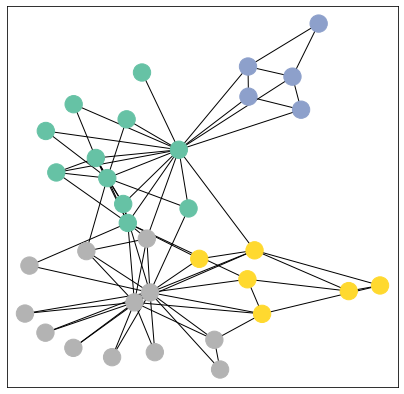

In [18]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize(G, color=data.y)

接下里，我们先使用一个最简单的图神经网络GCN来看看效果。

PyG已经帮我们把一些常用的GNN封装好了，我们在forward方法中，记得把节点特证和COO边数据传递进行。

In [19]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


定义网络时，我们现在构造方法中把我们的每一层定义好，再在forward方法正进行层的拼接，也就是前向传播。这里我们定义了三层的GCN，也就是说，我们这里考虑的是3跳的邻居节点信息，我们的维度变化$34 \rightarrow 4 \rightarrow 4 \rightarrow 2$，每一层的GCN包含一tanh的激活函数

最后我们采用一个简单的全连接层做一个分类，把所有的节点映射到4个类别上

我们返回最终分类器的输出以及GNN生成的最终节点embedding。

使用时，我们通过GCN()来实例化我们的模型。

接下来我们可视化的方法来看下通过GCN得到的节点embedding，我们通过传递节点特证x和边的数据来建模就，最终得到的二维的可视化embedding如下

Embedding shape: [34, 2]


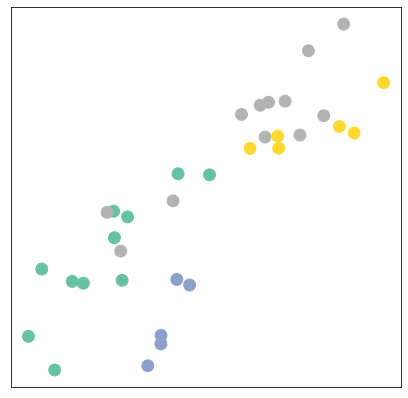

In [20]:
model = GCN()

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize(h, color=data.y)

看到这里就很有意思了，即使我们没有训练那我们的模型，这个模型生成的embedding仍然能让同一个社区的节点尽可能的靠在一起，而我们的网络节点的参数实际上都是随机初始化的，并且我们也并没有做个任何的预训练，这就得出结论，GNNs引入了一个很强的归纳偏差，导致在输入图中相互靠近的节点具有相似的嵌入。

那我们能让其效果更好吗，接下来，我们就来训练下我们的模型，让我们看下如何基于图中4个节点的社区分配知识来训练网络参数。

由于我们模型中的所有东西都是可微的和参数化的，所以我们可以添加一些标签，训练模型并观bp之后的效果。这里我们使用了半监督学习过程：我们只需针对每个类的一个节点进行训练，但是需要输入全部图的边信息。

训练过程和普通的网络训练过程一样，定义我们的模型，定义损失函数，然后进行参数更新。

需要注意的是，我们的损失函数使用时只考虑训练数据

```
loss = criterion(out[data.train_mask], data.y[data.train_mask])
```

<IPython.core.display.Javascript object>

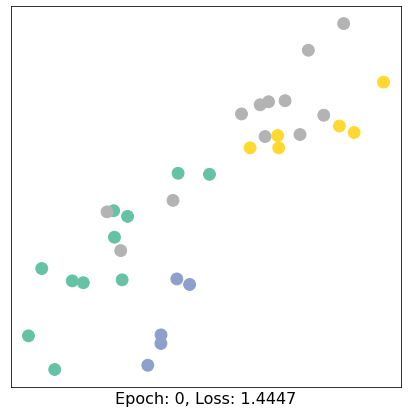

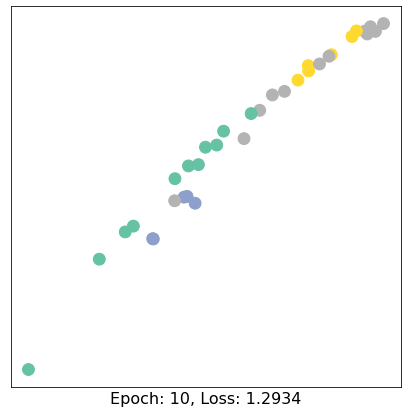

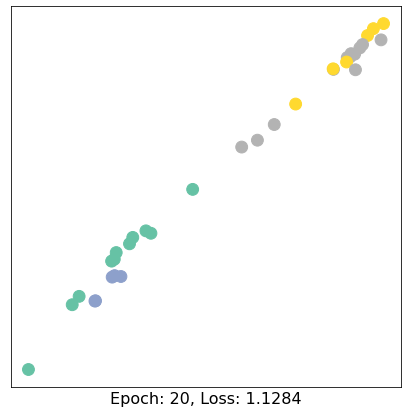

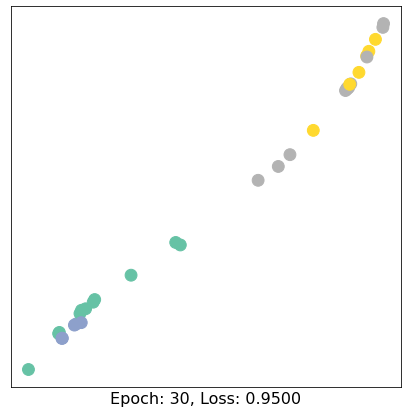

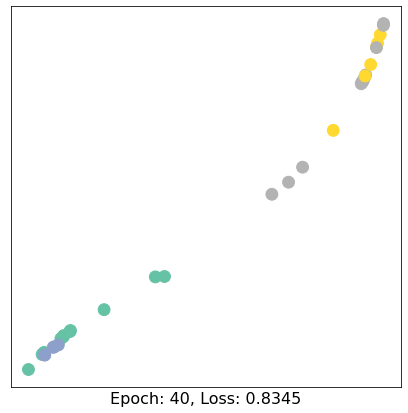

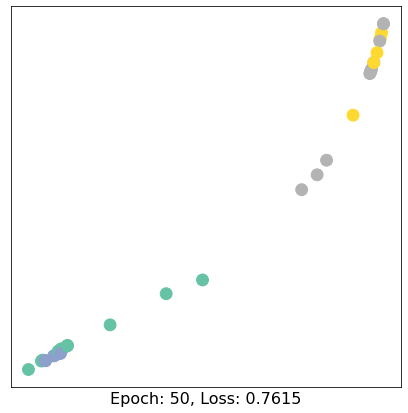

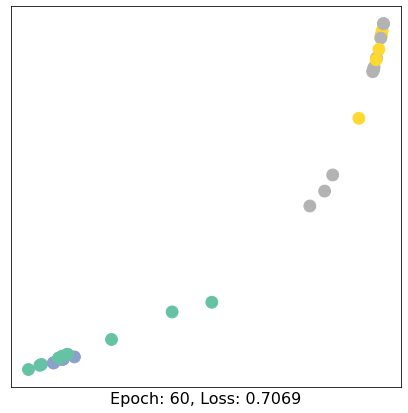

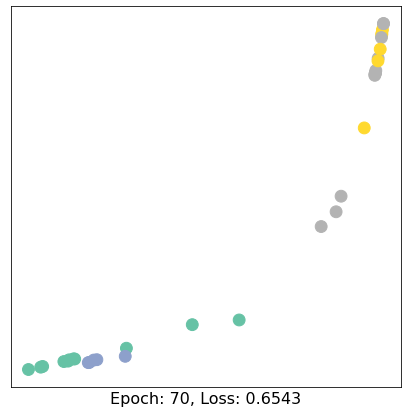

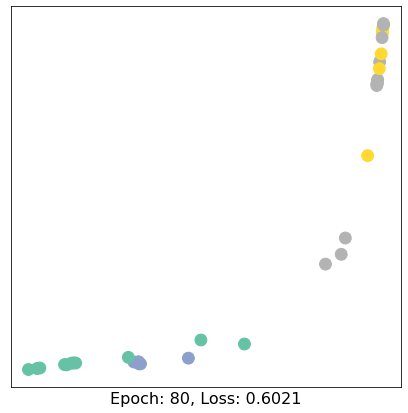

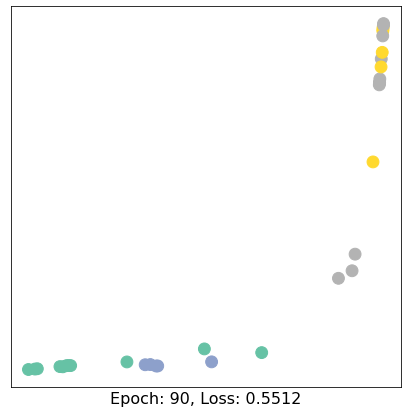

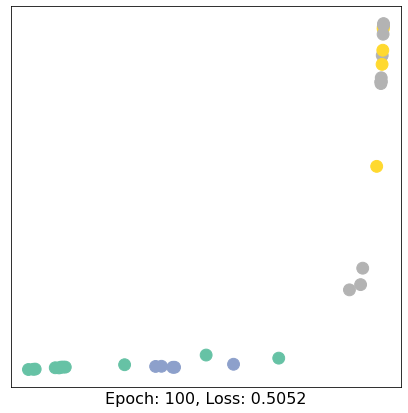

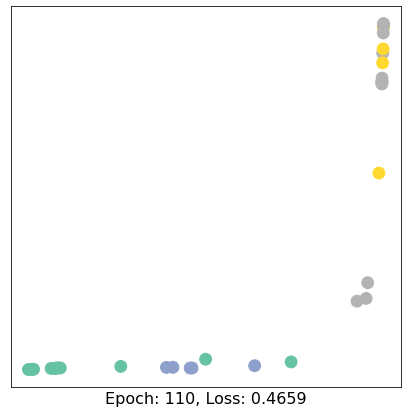

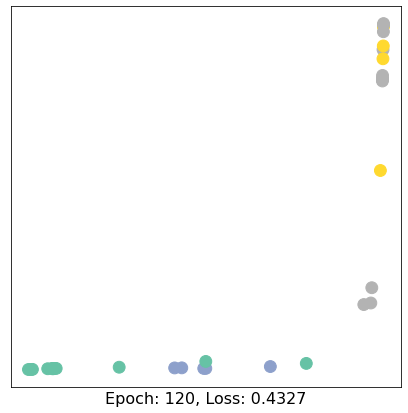

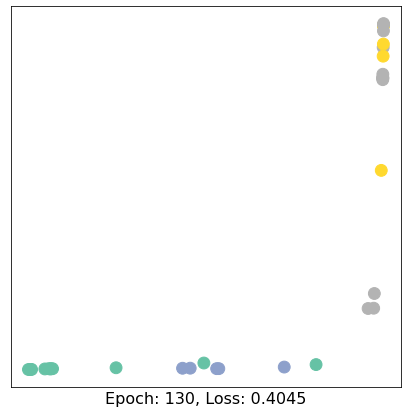

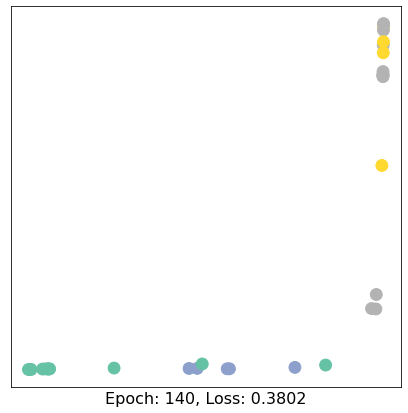

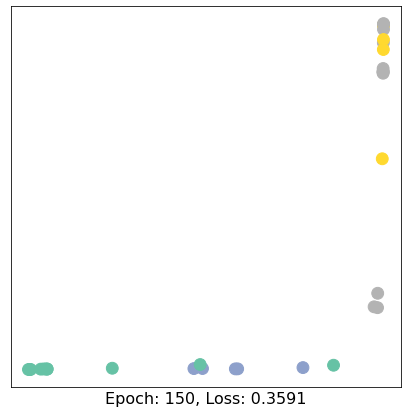

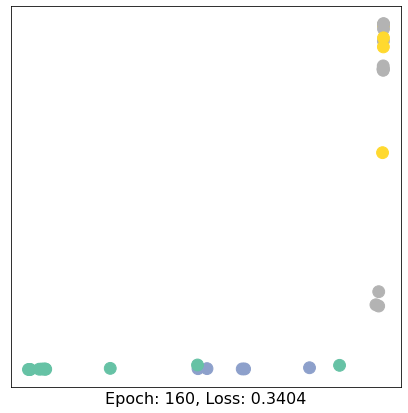

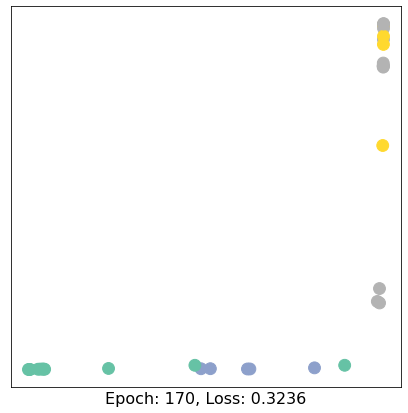

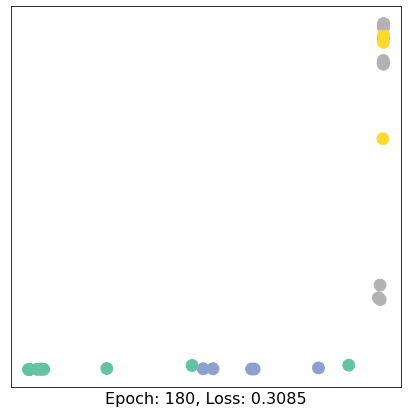

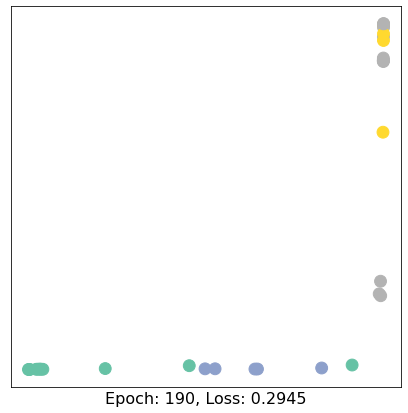

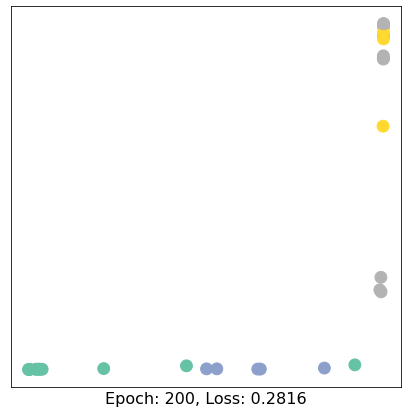

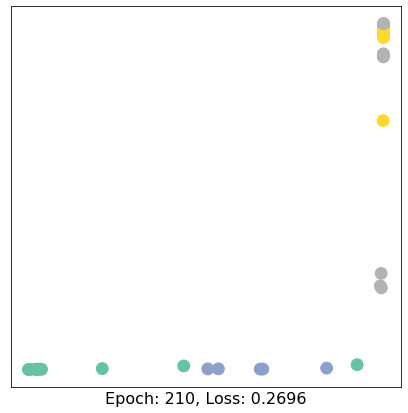

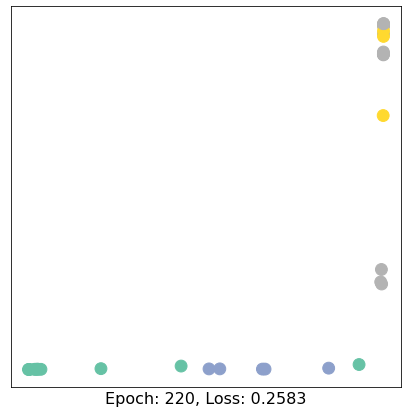

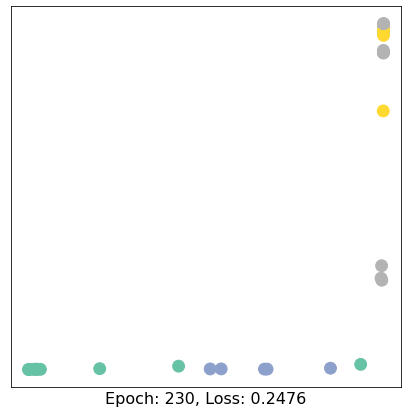

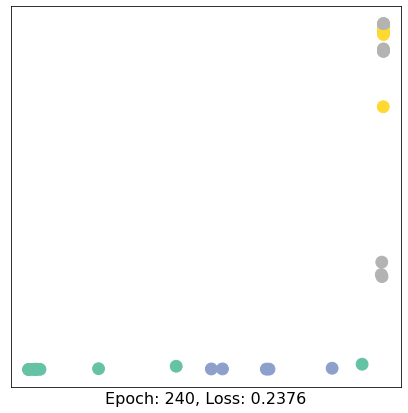

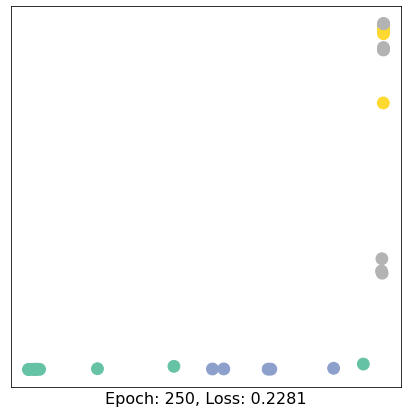

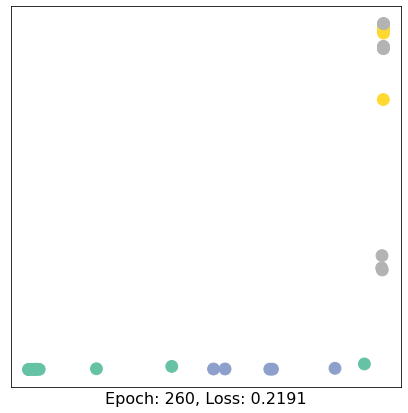

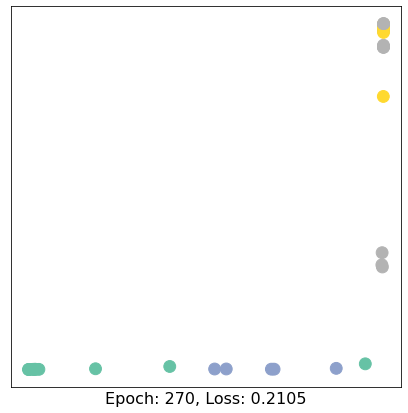

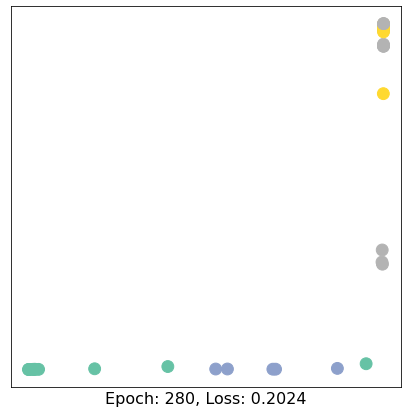

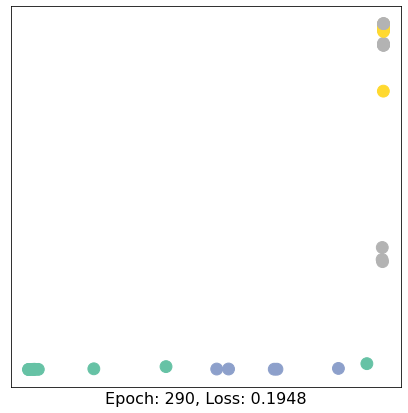

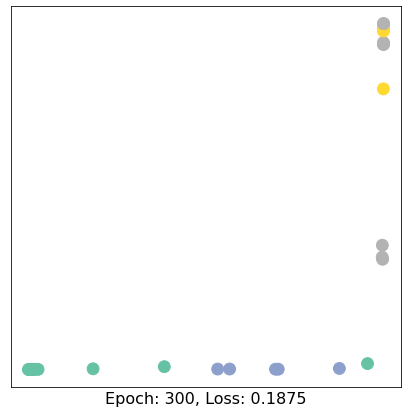

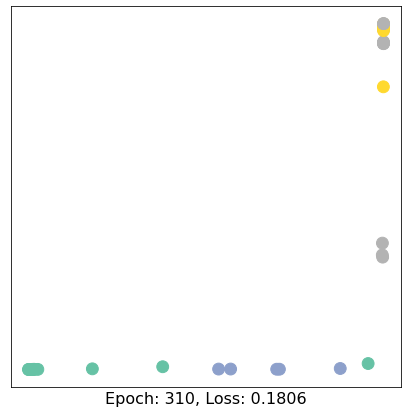

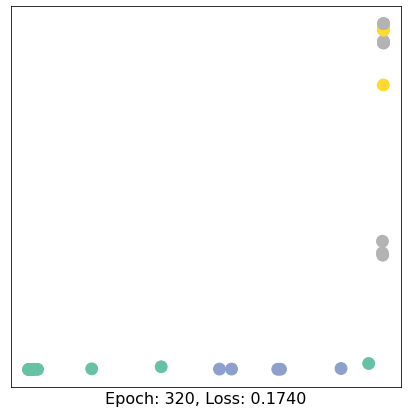

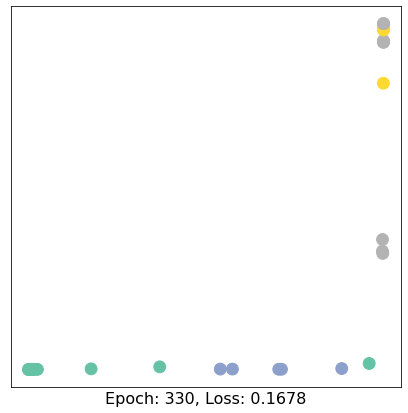

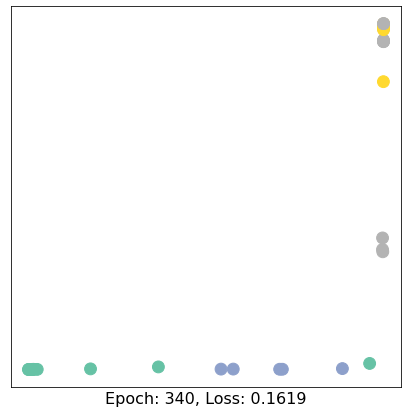

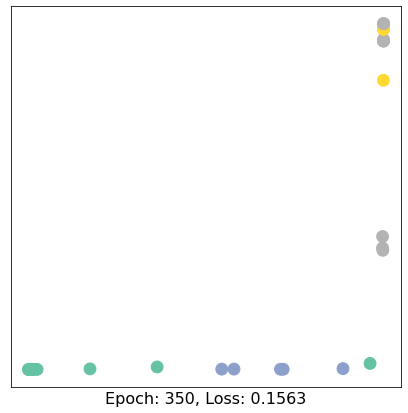

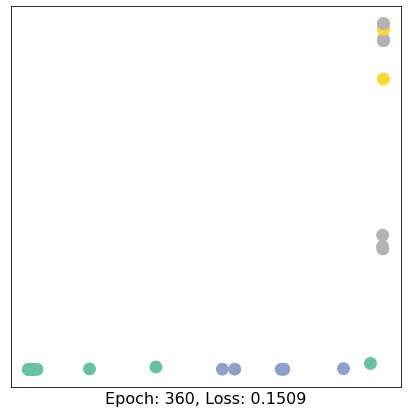

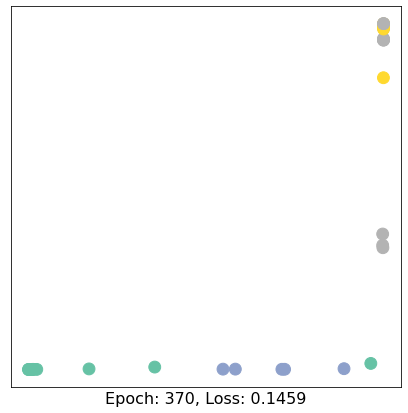

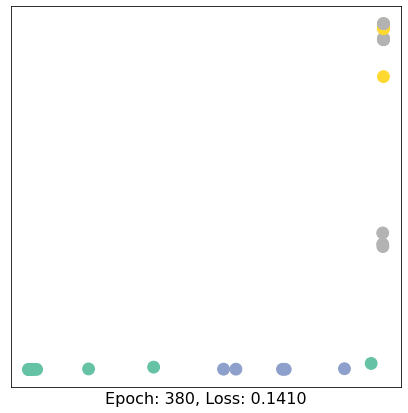

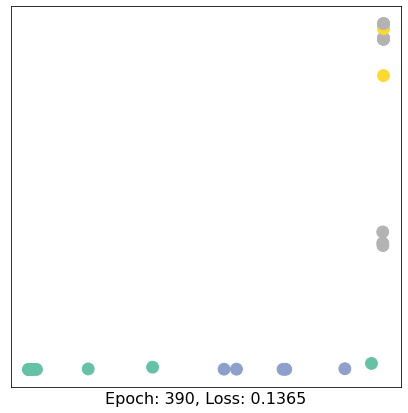

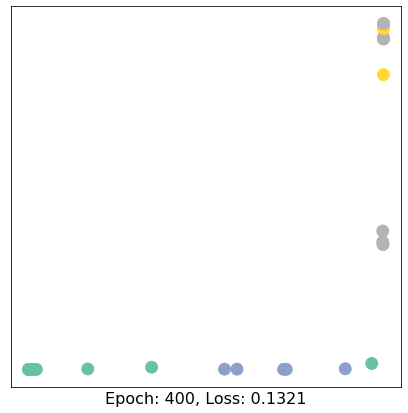

In [21]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

for epoch in range(401):
    loss, h = train(data)
    if epoch % 10 == 0:
        visualize(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)

可以看到，三层的GCN效果就已经很不错了，并且我们在借助PyG这个库的帮助下，几行代码就实现了我们的功能。

接下来我们来看一个更大一点的图，并对比下GCN和NN的效果。

Cora network是一个论文引用的关系图，包含了2780个节点，10556条边，每个节点的平均度是3.9，参与训练的节点是140个，也就是其中的5%的节点数据。


In [24]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='/Users/zhaojiuzhou/data', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...
Done!

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


我们先来验证下，如果只使用普通的MLP，效果怎么样

In [25]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(MLP, self).__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


我们的感知机有两层，第一层是从1433做了一个维度的变换，第二层是一个分类层，输出类别数。

接下来进行训练。



In [26]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9615
Epoch: 002, Loss: 1.9557
Epoch: 003, Loss: 1.9505
Epoch: 004, Loss: 1.9423
Epoch: 005, Loss: 1.9327
Epoch: 006, Loss: 1.9279
Epoch: 007, Loss: 1.9144
Epoch: 008, Loss: 1.9087
Epoch: 009, Loss: 1.9023
Epoch: 010, Loss: 1.8893
Epoch: 011, Loss: 1.8776
Epoch: 012, Loss: 1.8594
Epoch: 013, Loss: 1.8457
Epoch: 014, Loss: 1.8365
Epoch: 015, Loss: 1.8280
Epoch: 016, Loss: 1.7965
Epoch: 017, Loss: 1.7984
Epoch: 018, Loss: 1.7832
Epoch: 019, Loss: 1.7495
Epoch: 020, Loss: 1.7441
Epoch: 021, Loss: 1.7188
Epoch: 022, Loss: 1.7124
Epoch: 023, Loss: 1.6785
Epoch: 024, Loss: 1.6660
Epoch: 025, Loss: 1.6119
Epoch: 026, Loss: 1.6236
Epoch: 027, Loss: 1.5827
Epoch: 028, Loss: 1.5784
Epoch: 029, Loss: 1.5524
Epoch: 030, Loss: 1.5020
Epoch: 031, Loss: 1.5065
Epoch: 032, Loss: 1.4742
Epoch: 033, Loss: 1.4581
Epoch: 034, Loss: 1.4246
Epoch: 035, Loss: 1.4131
Epoch: 036, Loss: 1.4112
Epoch: 037, Loss: 1.3923
Epoch: 038, Loss: 1.3055
Epoch: 039, Loss: 1.2982
Epoch: 040, Loss: 1.2543


In [27]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5900


可以看到MLP只有59的准确率，为啥MLP效果不够理想呢，其主要原因是该模型由于训练节点数量少而存在严重的过拟合问题，因而对不可见节点表示的泛化能力较差。

其次它也没有将一个重要的关系纳入到模型中：被引用的论文很可能与文档的类别有关。这正是图神经网络发挥作用的地方，有助于提高我们模型的性能。

接下来我们来试试图神经网络

In [28]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


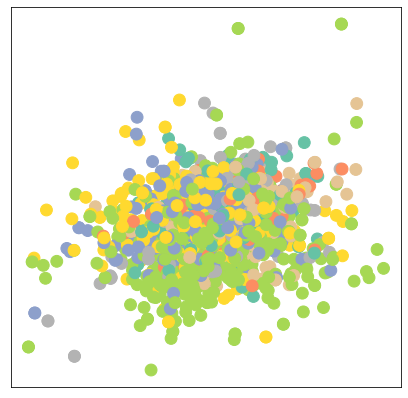

In [29]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [30]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9451
Epoch: 002, Loss: 1.9384
Epoch: 003, Loss: 1.9307
Epoch: 004, Loss: 1.9227
Epoch: 005, Loss: 1.9126
Epoch: 006, Loss: 1.9076
Epoch: 007, Loss: 1.8917
Epoch: 008, Loss: 1.8809
Epoch: 009, Loss: 1.8728
Epoch: 010, Loss: 1.8616
Epoch: 011, Loss: 1.8453
Epoch: 012, Loss: 1.8397
Epoch: 013, Loss: 1.8237
Epoch: 014, Loss: 1.8057
Epoch: 015, Loss: 1.7979
Epoch: 016, Loss: 1.7808
Epoch: 017, Loss: 1.7667
Epoch: 018, Loss: 1.7555
Epoch: 019, Loss: 1.7436
Epoch: 020, Loss: 1.7184
Epoch: 021, Loss: 1.7126
Epoch: 022, Loss: 1.6845
Epoch: 023, Loss: 1.6717
Epoch: 024, Loss: 1.6673
Epoch: 025, Loss: 1.6353
Epoch: 026, Loss: 1.6181
Epoch: 027, Loss: 1.5962
Epoch: 028, Loss: 1.5723
Epoch: 029, Loss: 1.5708
Epoch: 030, Loss: 1.5370
Epoch: 031, Loss: 1.5162
Epoch: 032, Loss: 1.4948
Epoch: 033, Loss: 1.4713
Epoch: 034, Loss: 1.4589
Epoch: 035, Loss: 1.4479
Epoch: 036, Loss: 1.4377
Epoch: 037, Loss: 1.4271
Epoch: 038, Loss: 1.3644
Epoch: 039, Loss: 1.3658
Epoch: 040, Loss: 1.3363


In [31]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8140


通过简单地用GNN层，我们可以达到81.4%的准确率，这与MLP获得的59%的测试准确率形成了鲜明对比，表明关系信息在获得更好的性能方面起着至关重要的作用。



我们还可以通过查看经过训练的模型的输出嵌入来再次验证这一点，该模型现在可以生成更好的同类节点聚类。

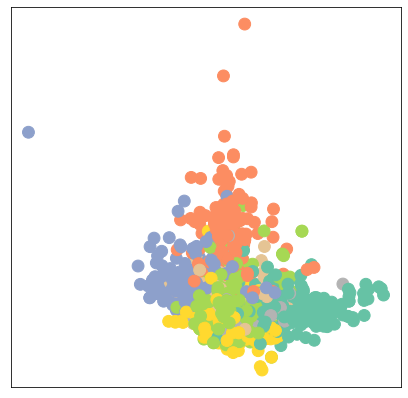

In [32]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

看完节点分类，我们再来看一下图分类任务

图分类最常见的任务是分子性质预测，其中分子被表示为图，任务可能是推断一个分子是否抑制HIV病毒复制。



多特蒙德大学收集了大量不同的图形分类数据集，称为TU dataset

In [33]:
import torch
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Extracting data/TUDataset/MUTAG/MUTAG.zip
Processing...
Done!

Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_attr=[38, 4], edge_index=[2, 38], x=[17, 7], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


这个数据集包含了188个不同的图，这个任务是把每个图分到两个不同的类别。

可以看到，第一个图包含了17个节点，38条边，每条边还有额外的4个属性。

这里我们选用前150个子图做为训练数据，其他做为测试数据

In [34]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


由于图形分类数据集中的图形通常很小，一个好主意是在将图形输入到图形神经网络之前对其进行批处理，以保证GPU的充分利用。在nlp领域，通常通过将每个示例重新缩放或填充为一组大小相等的形状来实现此过程，然后将示例分组到另一个维度中。这个维度的长度等于一个小批量中分组的示例数，通常称为批量大小。



然而，对于GNNs，上述方法要么不可行，要么可能导致大量不必要的内存消耗。因此，PyG选择了另一种方法来实现跨多个示例的并行化。在这里，邻接矩阵以对角方式堆叠（创建包含多个孤立子图的巨型图），节点和目标特征在节点维度中简单地串联：


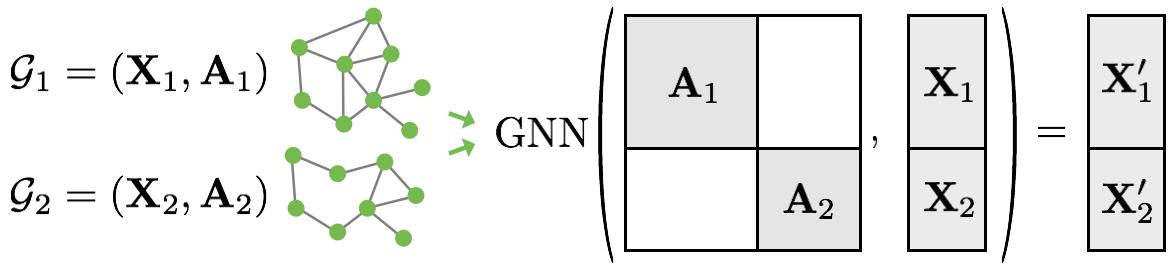

这样做的优势是：

1、依赖于消息传递方案的GNN操作符不需要修改，因为消息不会在属于不同图的两个节点之间交换。

2、由于邻接矩阵以稀疏的方式保存，只保存非零的条目即边，因此没有计算或内存开销。


In [35]:
from torch_geometric.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
Batch(batch=[1169], edge_attr=[2592, 4], edge_index=[2, 2592], x=[1169, 7], y=[64])

Step 2:
Number of graphs in the current batch: 64
Batch(batch=[1116], edge_attr=[2444, 4], edge_index=[2, 2444], x=[1116, 7], y=[64])

Step 3:
Number of graphs in the current batch: 22
Batch(batch=[429], edge_attr=[958, 4], edge_index=[2, 958], x=[429, 7], y=[22])



使用GNN训练图分类步骤如下：

1、对每个节点进行embedding

2、对所有节点的embedding进行聚合

3、训练分类层

聚合最简单的办法就是取均值

$$
\mathbf{x}_{\mathcal{G}} = \frac{1}{|\mathcal{V}|} \sum_{v \in \mathcal{V}} \mathcal{x}^{(L)}_v
$$


PyG提供了一个方法，来获取全局的节点embedding的均值，最后我们把均值给到分类层就完成了端到端的训练。


In [36]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [37]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 201):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 002, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 003, Train Acc: 0.6467, Test Acc: 0.7368
Epoch: 004, Train Acc: 0.6533, Test Acc: 0.7368
Epoch: 005, Train Acc: 0.6667, Test Acc: 0.7632
Epoch: 006, Train Acc: 0.7267, Test Acc: 0.8158
Epoch: 007, Train Acc: 0.7200, Test Acc: 0.7632
Epoch: 008, Train Acc: 0.7133, Test Acc: 0.7632
Epoch: 009, Train Acc: 0.7200, Test Acc: 0.8158
Epoch: 010, Train Acc: 0.7133, Test Acc: 0.7895
Epoch: 011, Train Acc: 0.7267, Test Acc: 0.7632
Epoch: 012, Train Acc: 0.7200, Test Acc: 0.7895
Epoch: 013, Train Acc: 0.7133, Test Acc: 0.8158
Epoch: 014, Train Acc: 0.7400, Test Acc: 0.7632
Epoch: 015, Train Acc: 0.7533, Test Acc: 0.7368
Epoch: 016, Train Acc: 0.7533, Test Acc: 0.7368
Epoch: 017, Train Acc: 0.7267, Test Acc: 0.7895
Epoch: 018, Train Acc: 0.7267, Test Acc: 0.7895
Epoch: 019, Train Acc: 0.7267, Test Acc: 0.7895
Epoch: 020, Train Acc: 0.7333, Test Acc: 0.7632
Epoch: 021, Train Acc: 0.7400, Test Acc:

Epoch: 173, Train Acc: 0.8267, Test Acc: 0.7105
Epoch: 174, Train Acc: 0.7867, Test Acc: 0.7632
Epoch: 175, Train Acc: 0.7933, Test Acc: 0.7632
Epoch: 176, Train Acc: 0.8333, Test Acc: 0.7368
Epoch: 177, Train Acc: 0.8133, Test Acc: 0.7368
Epoch: 178, Train Acc: 0.8333, Test Acc: 0.7368
Epoch: 179, Train Acc: 0.8200, Test Acc: 0.7105
Epoch: 180, Train Acc: 0.8267, Test Acc: 0.7632
Epoch: 181, Train Acc: 0.8133, Test Acc: 0.7368
Epoch: 182, Train Acc: 0.8267, Test Acc: 0.7632
Epoch: 183, Train Acc: 0.8133, Test Acc: 0.7368
Epoch: 184, Train Acc: 0.8067, Test Acc: 0.8158
Epoch: 185, Train Acc: 0.8200, Test Acc: 0.7368
Epoch: 186, Train Acc: 0.8267, Test Acc: 0.6842
Epoch: 187, Train Acc: 0.8267, Test Acc: 0.7368
Epoch: 188, Train Acc: 0.7867, Test Acc: 0.7632
Epoch: 189, Train Acc: 0.8133, Test Acc: 0.7368
Epoch: 190, Train Acc: 0.8267, Test Acc: 0.7368
Epoch: 191, Train Acc: 0.8200, Test Acc: 0.7105
Epoch: 192, Train Acc: 0.7933, Test Acc: 0.7895
Epoch: 193, Train Acc: 0.8333, Test Acc: